In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from pdpbox import pdp
from sklearn.preprocessing import LabelEncoder

In [3]:
def get_correlated_feats(df, thresh=0.5):
    """ Determines correlated feature pairs in a dataframe.
    
        Arguments:
            - df [Pandas]: dataframe
            - thresh [float]: desired threshold for determining correlation

        Returns:
            corr_feats [list]: list of correlated feature pairs
            uncorr_feats [list]: list of uncorrelated feature pairs
    """

    corr = df.corr()
    corr_mat = corr.to_numpy()
    num_feats = corr.shape[0]
    feat_names = list(corr.columns)

    corr_feats = []
    for i in range(num_feats):
        for j in range(i, num_feats):
            if (i !=j) and (corr_mat[i,j] >= thresh):
                corr_feats.append((feat_names[i], feat_names[j]))

    return corr_feats

In [4]:
def drop_correlated_feats(df, corr_feats, feats_analyze):
    """ Drops features correlated with the features to analyze via a PDP plot.
    
        Arguments:
            - df [Pandas]: dataframe
            - corr_feats [list]: list of pairwise correlated features (Pearson)
            - feats_analyze [list]: list of features to analyze via a PDP plot
        Returns:
            - df [Pandas]: dataframe after dropping correlated features
    """
                
    for (f1, f2) in corr_feats:
        for feat in feats_analyze:
            if feat in (f1, f2):
                if (feat != f1) and (f1 in df.columns):
                    df.drop(columns=[f1], inplace=True)
                elif (feat != f2) and (f2 in df.columns):
                    df.drop(columns=[f2], inplace=True)
            
    return df

In [5]:
def label_encoded_data(data, ignore_features):
    """
    Label encodes the categorial features. This is determined by the columns 
    type as np.object in a pandas dataframe. 
    eg. ["yellow", "red", "black", "white", "red"] -> [0, 1, 2, 3, 1]

    Paramters:
        data (DataFrame): dataset 
        ignore_features (list): list feature that we are not interested 
            label encoded. 

    Returns:
        data (DataFrame): dataset that contain label encoded features 
    """


    data_dict = dict(data.dtypes)
    data = data.fillna(0)

    features = list(data.columns)

    for feature in ignore_features:
        features.remove(feature)


    le = LabelEncoder()

    for labels in features:
        # check if the column is categorical 

        if data_dict[labels] == np.object:
            data.loc[:, labels] = data.loc[:, labels].astype(str)
            data.loc[:, labels] = le.fit_transform(data.loc[:, labels])

    return data

In [6]:
def get_mdi_feature_importance(df, k, model):
    """ Prints the top k features using a Random Forest mean decrease in impurity (MDI)
        for determining feature importance.

        Arguments:
            - df [Pandas]: dataframe after encoding categorical features and target
            - k [int]: determines the top k features to print
            - model [str]: choice between Random Forest (RF) or XGBoost model (XGB)
         Returns:
            - sorted_feats [list]: list of top k important features
    """
    
    X = df.drop(columns=['OUTCOME'])
    y = df['OUTCOME'] 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    
    # balance data to have equal number of preterm and non-preterm births
    rus = RandomUnderSampler(random_state=42)
    X_train, y_train = rus.fit_resample(X_train, y_train)

    # fit model for feature importance
    if model == 'RF':
      clf = RandomForestClassifier(random_state=42)
    else:
      clf = XGBClassifier(random_state=42)
      
    clf.fit(X_train, y_train)
    
    importances = clf.feature_importances_
    feature_names = list(X_train.columns)

    feature_importances = []
    for feat, importance in zip(feature_names, importances):
        feature_importances.append([feat, importance*100])

    importance_df = pd.DataFrame(feature_importances, columns = ['Feature', 'Importance'])
    sorted_feats = list(importance_df.sort_values('Importance', ascending = False).iloc[0:k]['Feature'])
    
    # if the dataframe has fewer than k features, just show those features
    if importance_df.shape[0] < k:
      k = importance_df.shape[0]
    
    if k == 1:
      print(f"The top feature: \n")
    else:
      print(f"The top {k} features: \n")
    print(importance_df.sort_values('Importance', ascending = False).iloc[0:k])
    
    # make plot
    plt.style.use('bmh')
    sorted_importances = pd.Series(importances, index=feature_names).sort_values(ascending = False)[:k]
    fig, ax = plt.subplots(figsize=(15, 10))
    sorted_importances.plot.barh(ax=ax)
    ax.set_xlabel('Importance (Mean Decrease in Impurity)')
    ax.set_title('Feature Importance using MDI')
    plt.savefig('feature_importance_mdi.png', dpi=400)
    
    return sorted_feats

In [7]:
def plot_pdps(df, feats_to_analyze):
    """ Generates partial dependence plots (PDPs) for a selected subset of
      features from a given layer.

      Arguments:
        - df [Pandas]: raw dataframe
        - feats_to_analyze [list]: list of features to analyze

    """
  
    df_ready = label_encoded_data(df, ['OUTCOME'])
    X = df_ready.drop(columns=['OUTCOME'])
    y = df_ready['OUTCOME'] 
    
    # get all pairs of correlated features
    corr_feats = get_correlated_feats(X)
    
    for feat in feats_to_analyze:
      # remove all features correlated to the feature to analyze
      X = drop_correlated_feats(X, corr_feats, feat)
      X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
      model = XGBClassifier(objective='binary:logistic')
      model.fit(X_train, y_train)
      
      # make plots
      pdp_info = pdp.pdp_isolate(model=model, dataset=X_test, model_features=X_test.columns, feature=feat)
      fig, axes = pdp.pdp_plot(
      pdp_info, feat, center=False, frac_to_plot=0.1, plot_lines=True, x_quantile=True, show_percentile=True,
      plot_pts_dist=False, figsize=(16,9))

## Load in Data for Visit 2

In [11]:
df_9_2 = pd.read_csv('/data/V2.csv')

## Get Feature Importance

The top 20 features: 

         Feature  Importance
94        MAP_V1    4.246218
13          Race    3.862813
51        U2CD09    3.739731
32    INHIBINA_1    3.560792
14           BMI    3.349762
54      V1BA06a1    3.000691
88  VXXB01av_V2a    2.943375
45        U2CC05    2.759891
36        PLGF_1    2.637815
59      V2BA02a1    2.534699
35          PLGF    2.461642
49        U2CD06    2.413232
22    ENDOGLIN_1    2.398495
7       CLAC01f2    2.381330
21      ENDOGLIN    2.373121
24       SFLT1_1    2.272704
2      CLAB02d1b    2.086689
33         PAPPA    2.013657
20      ADAM12_1    1.928525
26        VEGF_1    1.893269


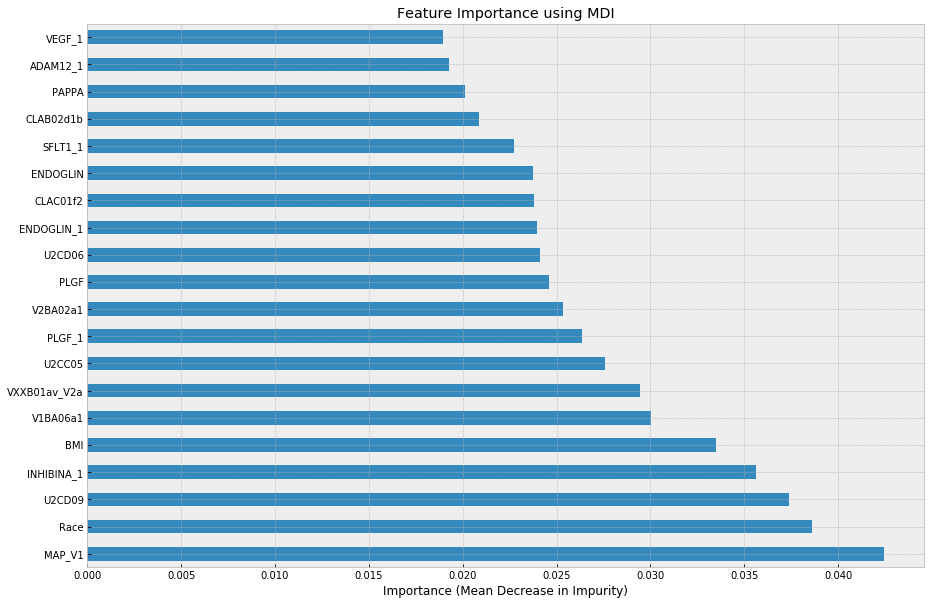

In [12]:
df_9_2 = df_9_2.drop(columns=['STUDYID', 'SFLT1c', 'PAPPAc', 'PLGFc'])
feat_imports = get_mdi_feature_importance(df_9_2, 20, 'XG')

## Plot PDPs of Top 20 Features

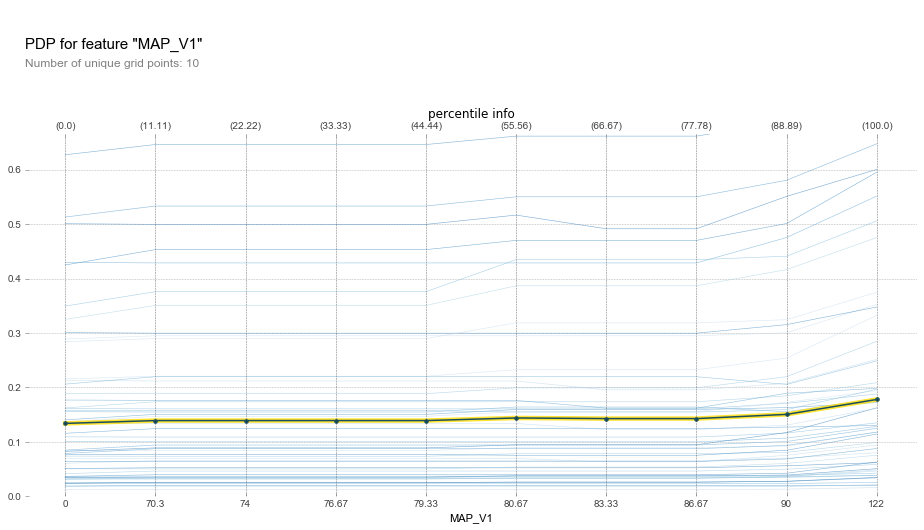

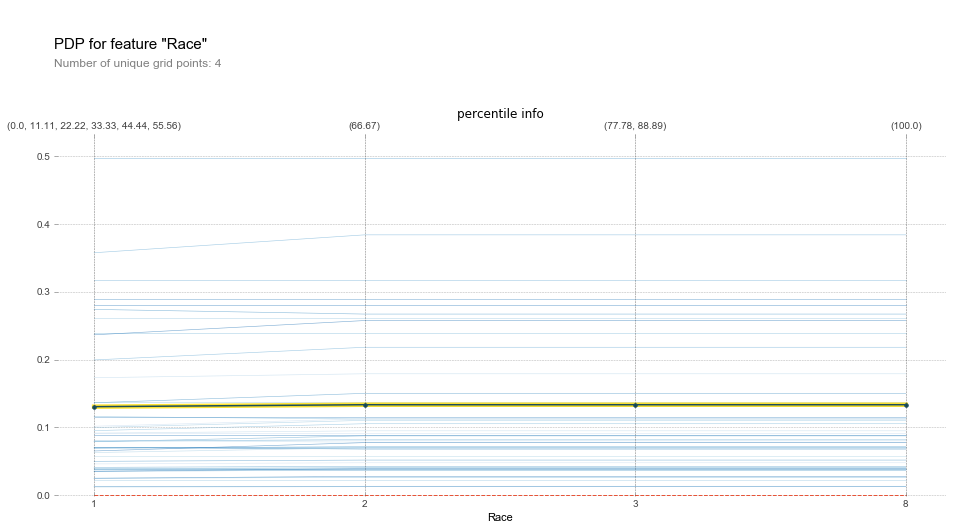

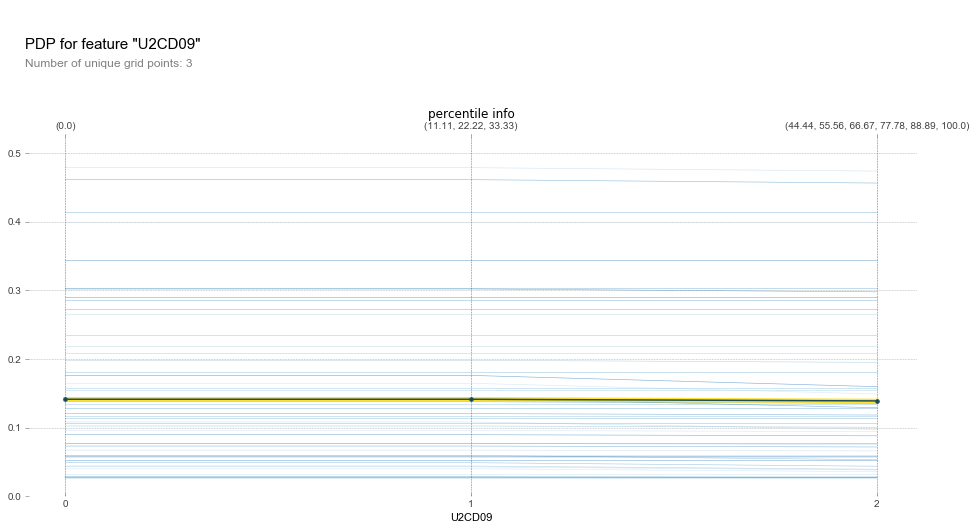

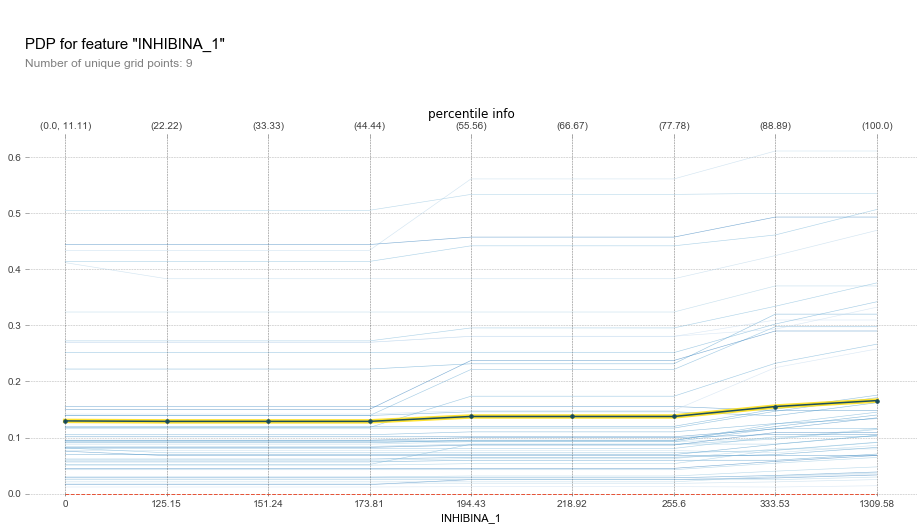

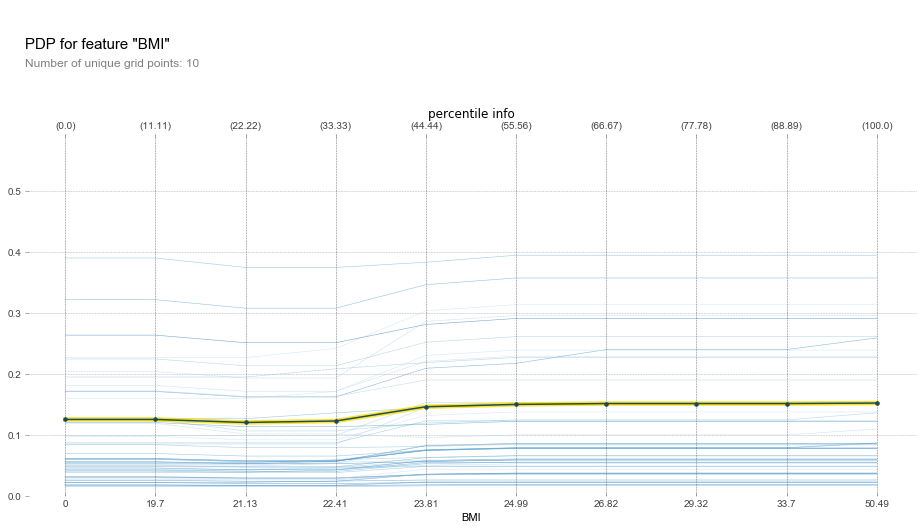

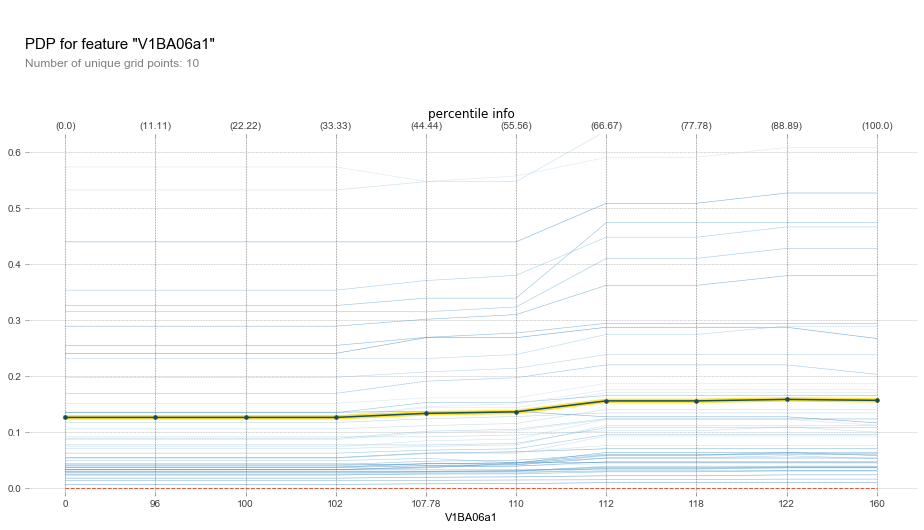

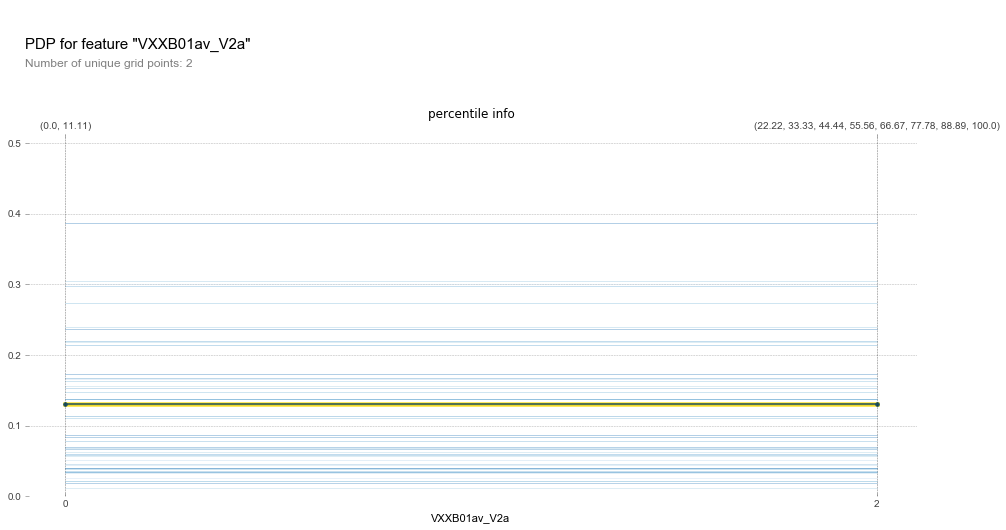

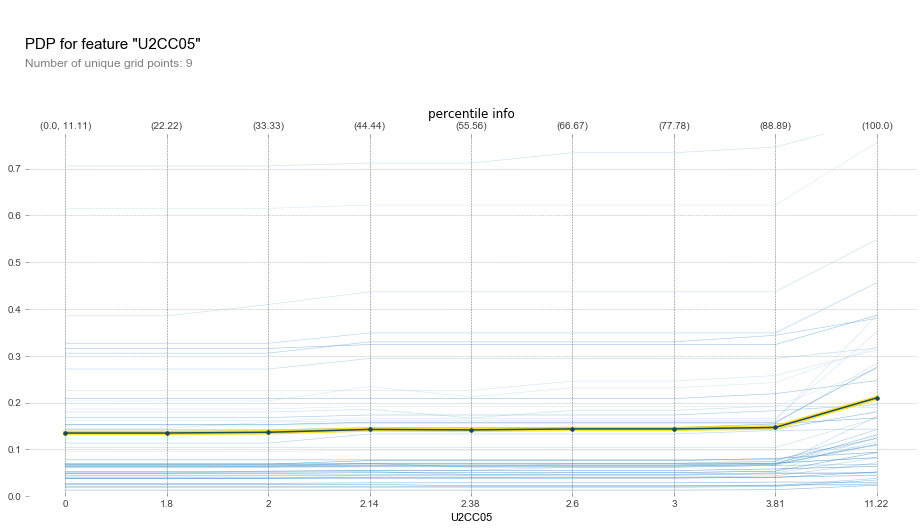

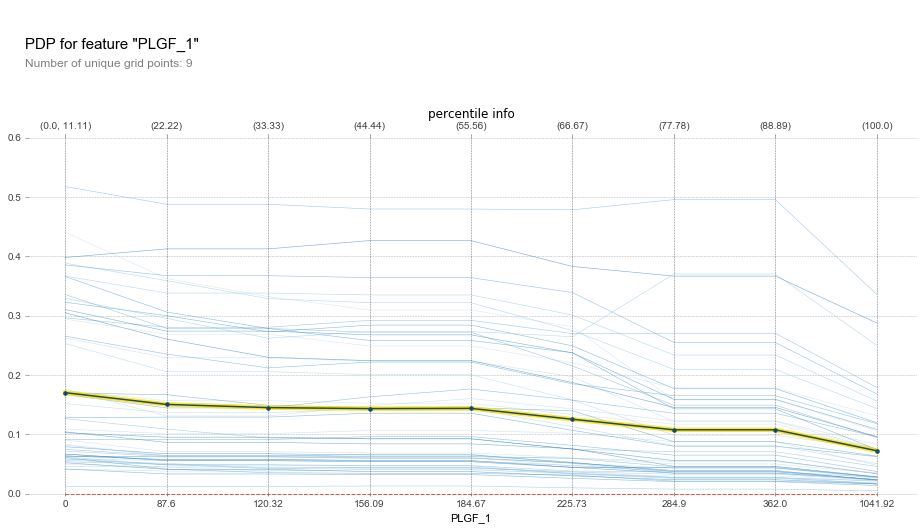

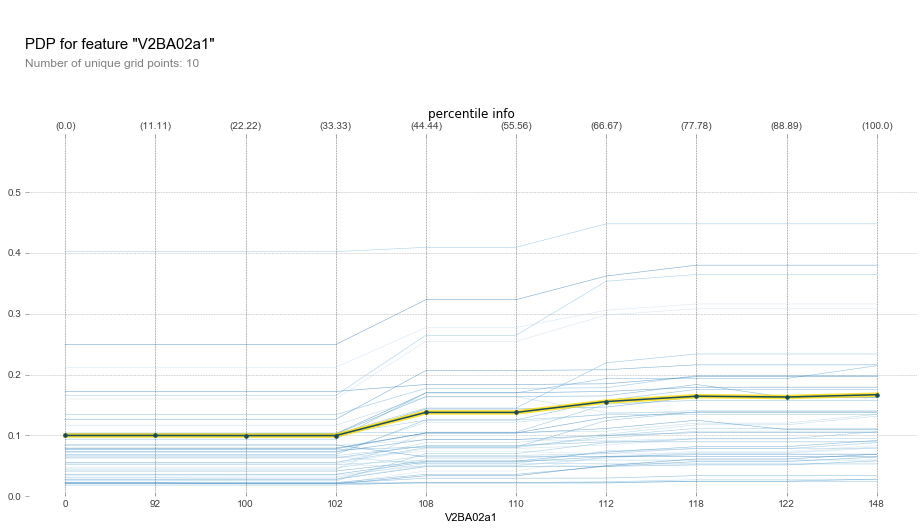

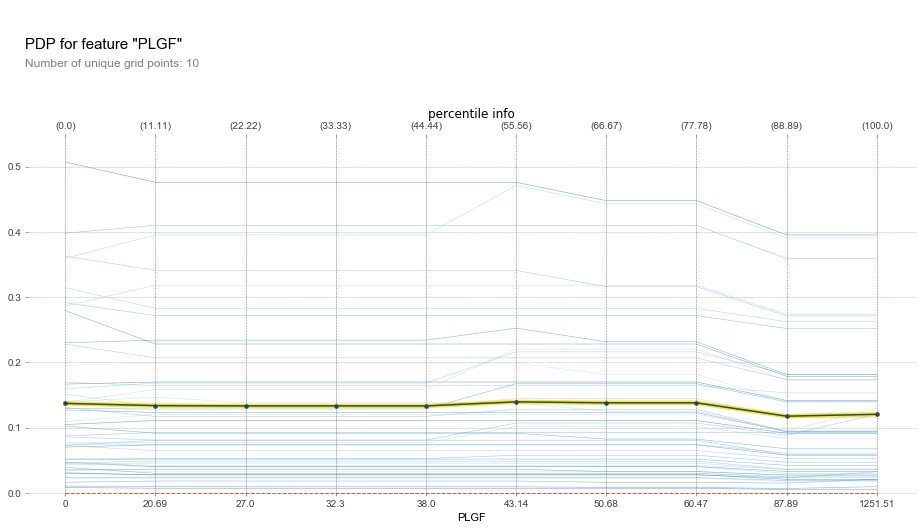

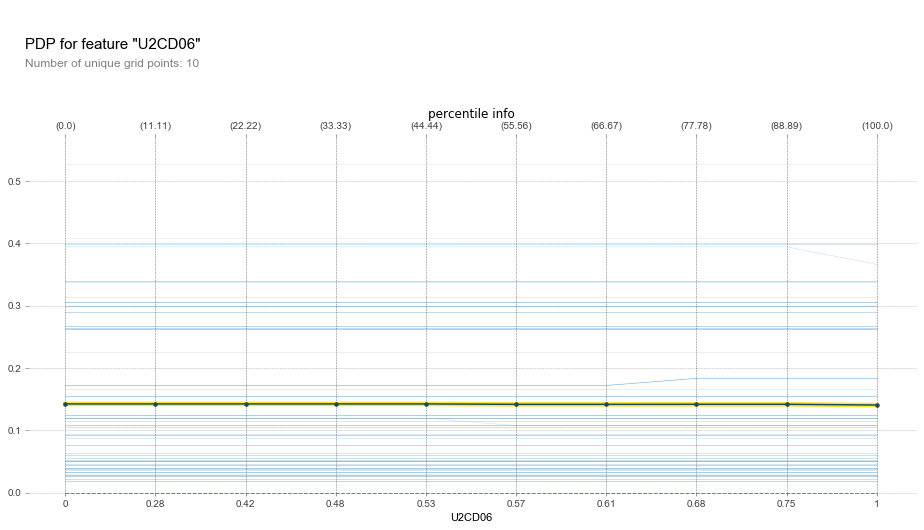

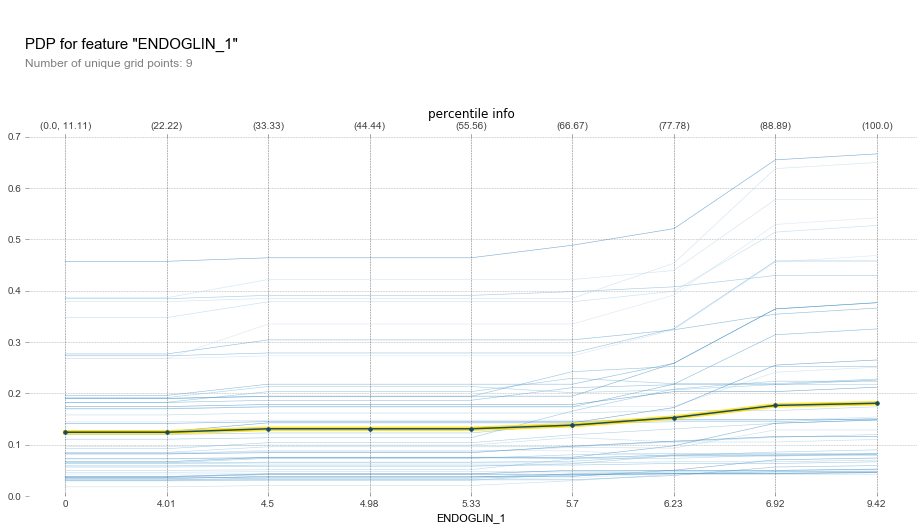

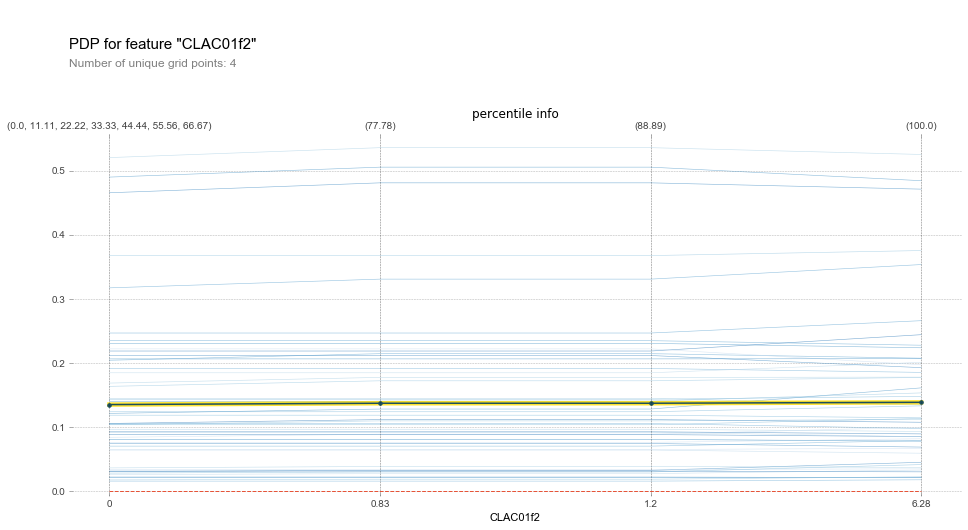

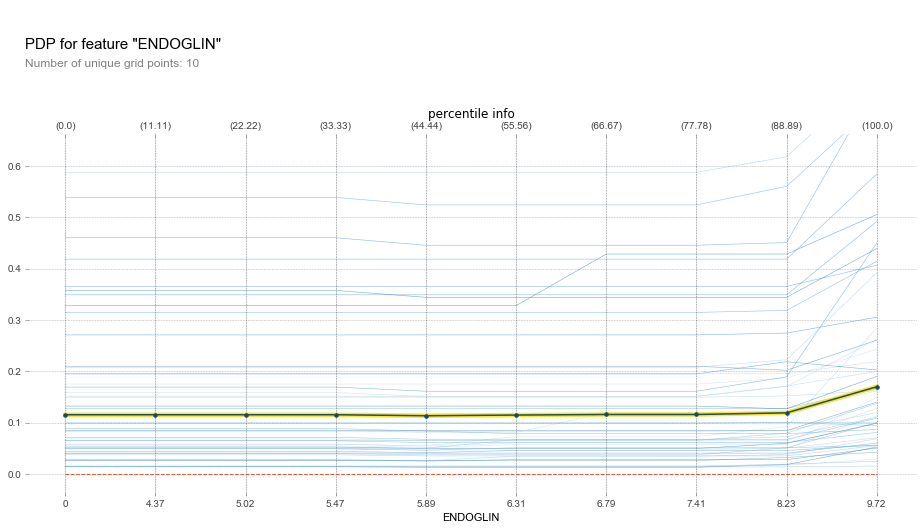

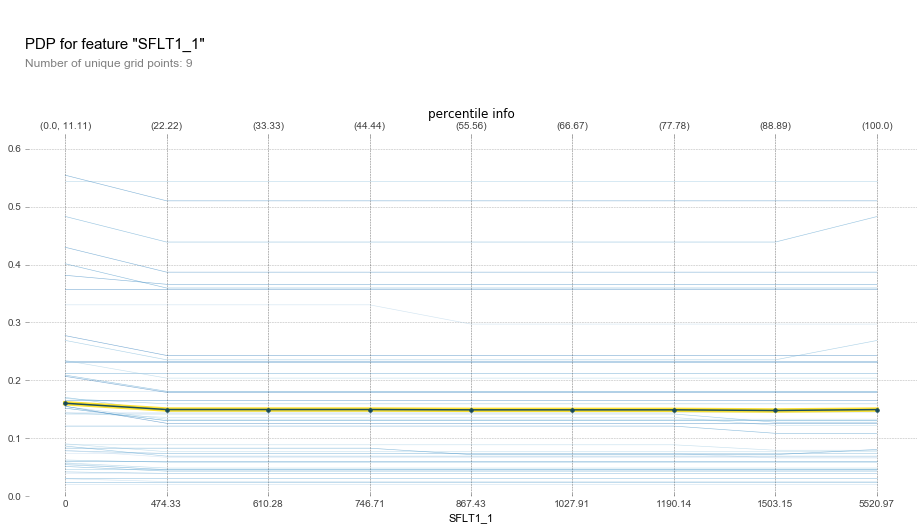

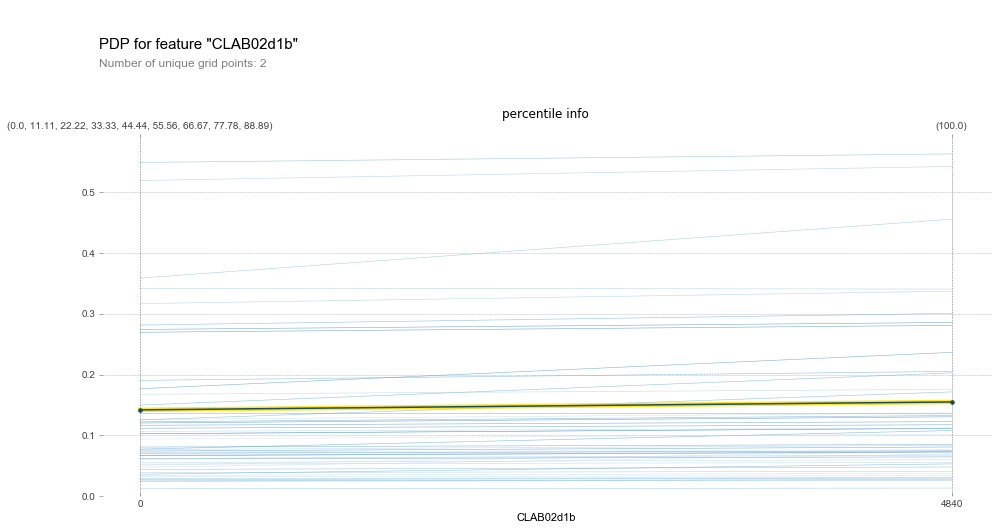

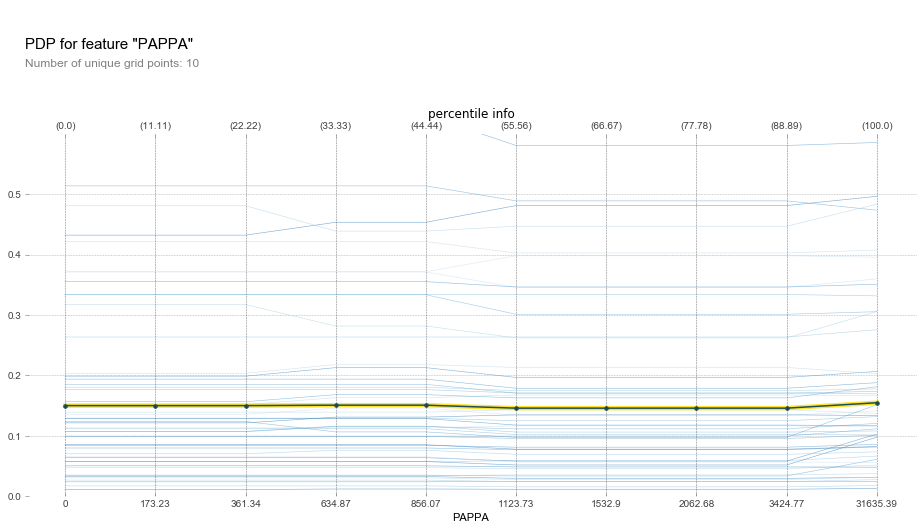

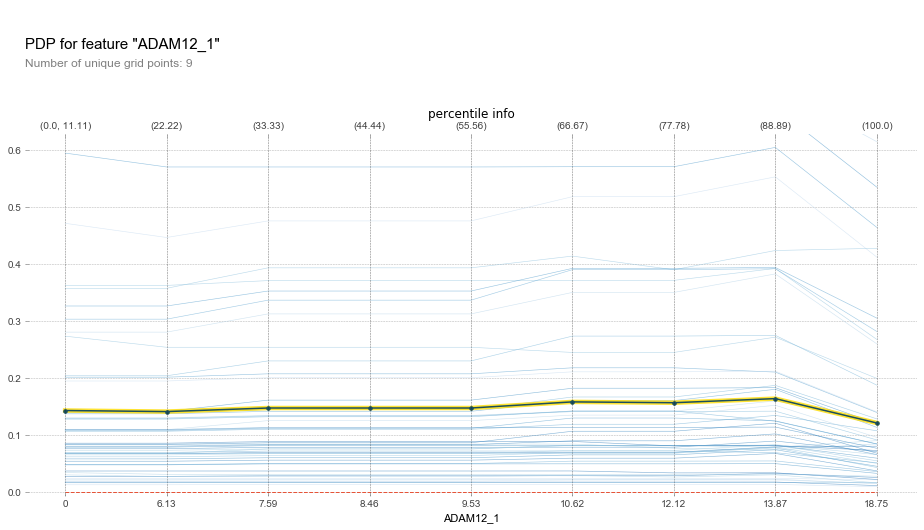

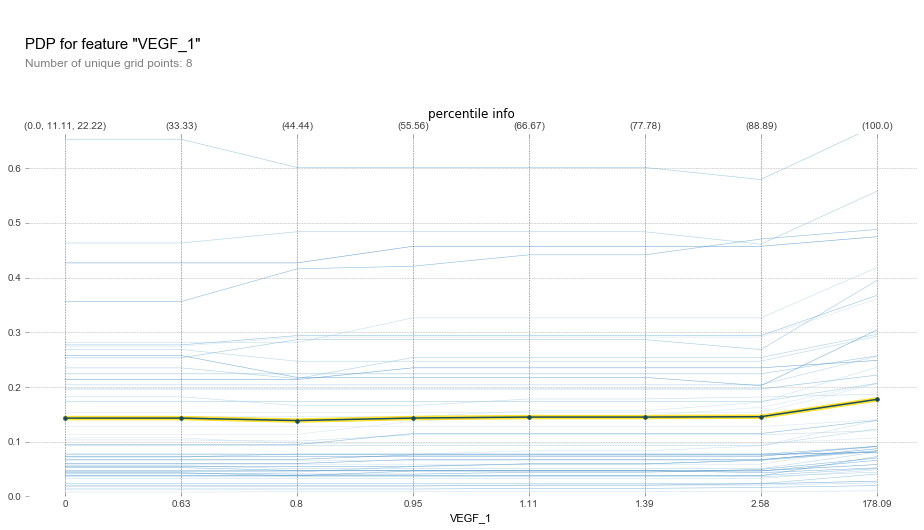

In [13]:
plot_pdps(df_9_2, feat_imports)